# QAOA memo


整数引数を持つコスト関数が与えらているとする。整数を適当な方法でbinaryにエンコードしたものを$C(x)$とする。

量子コンピュータを用いて、コスト関数を最小にする解を発見するために、コスト関数$C(x)$を対角要素に持つハミルトニアンを考える。
$$
H = \sum_{x\in\left\{0,1\right\}^n}C(x) \left|x\right>\left<x\right|
$$


コスト関数を最小化する$x$を発見する問題は、ハミルトニアン$H$の最小エネルギー固有値を持つ固有状態を発見する問題に置き換えることができる。

最小エネルギー固有状態の近似するために、次の形の試行関数を考える。
$$
\left|\psi(\gamma,\beta)\right> = \prod_{k=1}^pe^{-i\gamma_kH}e^{-i\beta_kB}\left|+\right>^n
$$

ここで、$B$は横磁場のハミルトニアンを表す。エネルギー期待値を最小化する$\gamma,\beta$が発見できれば、$\left|\psi(\gamma,\beta)\right> $はエネルギー最小の固有状態に近く、ビットを観測することで高い頻度でコスト関数最小解が得られると期待できる。

簡単な問題に対して、上記の計算を試みる。ハミルトニアンとして、
$$
H = Z_1-Z_2+Z_3-Z4
$$
を考える。これは、自明な解として、$(x_1,x_2,x_3,x_4)=(0,1,0,1)$を持つ。

また、試行関数は次のような簡単な形で表現できる。
$$
\left|\psi(\gamma,\beta)\right> = e^{-i\gamma Z_1}e^{+i\gamma Z_2} e^{-i\gamma Z_3} e^{-i\gamma Z_4} 
e^{i\beta X_1}e^{i\beta X_2}e^{i\beta X_3}e^{i\beta X_4}\left|+\right>^n
$$

# Calculation

In [1]:
! pip install pylatexenc

You should consider upgrading via the '/Users/s05904/work/2022_mirainage/1211_qiskit_qaoa/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, assemble, Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.opflow import Z, I

In [27]:
def build_quantum_circuit(bs, gamma, beta):
    n = len(bs)
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    for j in range(n):
        qc.rz(2*bs[j]*gamma, j)
    qc.rx(-2*beta, range(n))
    for j in range(n):
        qc.measure(j, j)
    return qc

def calc_expected_energy(result, bs):
    counts = result.get_counts()
    total_energy = 0
    shots = 0
    for sample in list(counts.keys()):
        xs = [int(n) for n in list(sample)]
        zs = np.array(xs) * 2 - 1
        eng = (zs * np.array(bs)).sum()
        n = counts[sample]
        total_energy += n * eng
        shots += n
    return total_energy / shots

def run_simulation(qc, shots):
    sim = Aer.get_backend("aer_simulator")
    tqc = transpile(qc, sim)
    qobj = assemble(qc, shots=shots)
    return sim.run(qobj).result()

ハミルトニアン
$$
H = Z_1-Z_2+Z_3-Z4
$$
に対して、$\beta=1, \gamma=0$の試行関数を使って1000回のシミュレーションを行う。

expected energy = 0.022


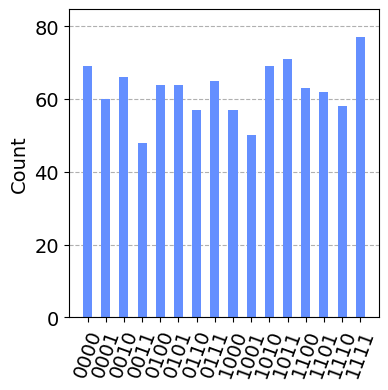

In [28]:
bs = [1.0, -1.0, 1.0, -1.0]
qc = build_quantum_circuit(bs=bs, gamma = 0.0, beta = 1.0)
result = run_simulation(qc, shots=1000)
expected_energy = calc_expected_energy(result, bs)
print("expected energy = {}".format(expected_energy))
plot_histogram(result.get_counts(), figsize=(4, 4), bar_labels = False)

エネルギー期待値は、最小エネルギー-4からは遠く、分布もまばらになっている。

グリッドサーチを用いて、エネルギー期待値を最小化するパラメータ$\gamma,\beta$を探索する。

In [13]:
bs = [1.0, -1.0, 1.0, -1.0]
mins = [10000, None, None]
for gamma in np.linspace(1.0, 3.0, 11):
    for beta in np.linspace(1.0, 3.0, 11):
        qc = build_quantum_circuit(bs=bs, gamma = gamma, beta = beta)
        result = run_simulation(qc, shots=1000)
        energy = calc_expected_energy(result, bs)
        if mins[0] > energy:
            mins[0] = energy
            mins[1] = gamma
            mins[2] = beta
mins

[-3.972, 2.4000000000000004, 2.4000000000000004]

最小エネルギー-4に近いエネルギー期待値が得られた。また、最小化パラメータとして、$\gamma=\beta=2.4$を得た。

得られたパラメータを使って、再度１０００回のsamplingを行う。

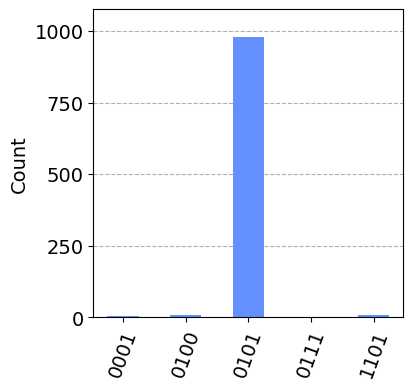

In [14]:
qc = build_quantum_circuit(bs=bs, gamma = 2.4, beta = 2.4)
result = run_simulation(qc, shots=1000)
plot_histogram(result.get_counts(), figsize = (4, 4), bar_labels = False)

自明な最小解である0101が非常に高い頻度で得られていることがわかる。